# Seasonality in time series data

Consider the problem of modeling time series data with multiple seasonal components with different periodicities.  Let us take the time series $y_t$ and decompose it explicitly to have a level component and two seasonal components.

$$
y_t = \mu_t + \gamma^{(1)}_t + \gamma^{(2)}_t
$$

where $\mu_t$ represents the trend or level, $\gamma^{(1)}_t$ represents a seasonal component with a relatively short period, and $\gamma^{(2)}_t$ represents another seasonal component of longer period. We will have a fixed intercept term for our level and consider both $\gamma^{(2)}_t$ and $\gamma^{(2)}_t$ to be stochastic so that the seasonal patterns can vary over time.

In this notebook, we will generate synthetic data conforming to this model and showcase modeling of the seasonal terms in a few different ways under the unobserved components modeling framework.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

### Synthetic data creation

We will create data with multiple seasonal patterns by following equations (3.7) and (3.8) in Durbin and Koopman (2012).  We will simulate 300 periods and two seasonal terms parametrized in the frequency domain having periods 10 and 100, respectively, and 3 and 2 number of harmonics, respectively.  Further, the variances of their stochastic parts are 4 and 9, respectively.

In [3]:
# First we'll simulate the synthetic data
def simulate_seasonal_term(periodicity, total_cycles, noise_std=1.0, harmonics=None):
    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration  # Pad for burn in
    series = np.zeros(total_timesteps)
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (
                gamma_jt[j - 1] * cos_j
                + gamma_star_jt[j - 1] * sin_j
                + noise_std * np.random.randn()
            )
            gamma_star_jtp1[j - 1] = (
                -gamma_jt[j - 1] * sin_j
                + gamma_star_jt[j - 1] * cos_j
                + noise_std * np.random.randn()
            )
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:]  # Discard burn in

    return wanted_series

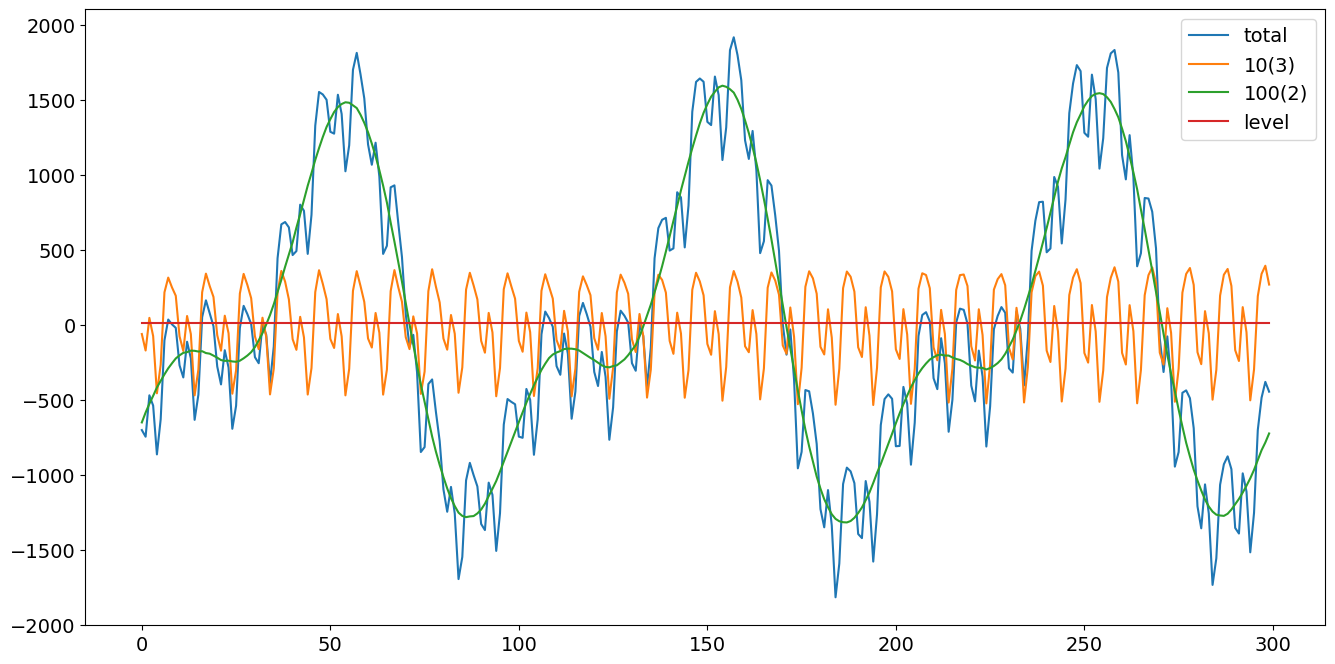

In [4]:
duration = 100 * 3
periodicities = [10, 100]
num_harmonics = [3, 2]
std = np.array([2, 3])
np.random.seed(8678309)

terms = []
for ix, _ in enumerate(periodicities):
    s = simulate_seasonal_term(
        periodicities[ix],
        duration / periodicities[ix],
        harmonics=num_harmonics[ix],
        noise_std=std[ix],
    )
    terms.append(s)
terms.append(np.ones_like(terms[0]) * 10.0)
series = pd.Series(np.sum(terms, axis=0))
df = pd.DataFrame(
    data={"total": series, "10(3)": terms[0], "100(2)": terms[1], "level": terms[2]}
)
(h1,) = plt.plot(df["total"])
(h2,) = plt.plot(df["10(3)"])
(h3,) = plt.plot(df["100(2)"])
(h4,) = plt.plot(df["level"])
plt.legend(["total", "10(3)", "100(2)", "level"])
plt.show()

### Unobserved components (frequency domain modeling)

The next method is an unobserved components model, where the trend is modeled as a fixed intercept and the seasonal components are modeled using trigonometric functions with primary periodicities of 10 and 100, respectively, and number of harmonics 3 and 2, respectively.  Note that this is the correct, generating model. The process for the time series can be written as:

$$
\begin{align}
y_t & = \mu_t + \gamma^{(1)}_t + \gamma^{(2)}_t + \epsilon_t\\
\mu_{t+1} & = \mu_t \\
\gamma^{(1)}_{t} &= \sum_{j=1}^2 \gamma^{(1)}_{j, t} \\
\gamma^{(2)}_{t} &= \sum_{j=1}^3 \gamma^{(2)}_{j, t}\\
\gamma^{(1)}_{j, t+1} &= \gamma^{(1)}_{j, t}\cos(\lambda_j) + \gamma^{*, (1)}_{j, t}\sin(\lambda_j) + \omega^{(1)}_{j,t}, ~j = 1, 2, 3\\
\gamma^{*, (1)}_{j, t+1} &= -\gamma^{(1)}_{j, t}\sin(\lambda_j) + \gamma^{*, (1)}_{j, t}\cos(\lambda_j) + \omega^{*, (1)}_{j, t}, ~j = 1, 2, 3\\
\gamma^{(2)}_{j, t+1} &= \gamma^{(2)}_{j, t}\cos(\lambda_j) + \gamma^{*, (2)}_{j, t}\sin(\lambda_j) + \omega^{(2)}_{j,t}, ~j = 1, 2\\
\gamma^{*, (2)}_{j, t+1} &= -\gamma^{(2)}_{j, t}\sin(\lambda_j) + \gamma^{*, (2)}_{j, t}\cos(\lambda_j) + \omega^{*, (2)}_{j, t}, ~j = 1, 2\\
\end{align}
$$


where $\epsilon_t$ is white noise, $\omega^{(1)}_{j,t}$ are i.i.d. $N(0, \sigma^2_1)$, and  $\omega^{(2)}_{j,t}$ are i.i.d. $N(0, \sigma^2_2)$, where $\sigma_1 = 2.$

                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                  300
Model:                                fixed intercept   Log Likelihood               -1145.631
                    + stochastic freq_seasonal(10(3))   AIC                           2295.261
                   + stochastic freq_seasonal(100(2))   BIC                           2302.594
Date:                                Mon, 12 Jan 2026   HQIC                          2298.200
Time:                                        18:26:18                                         
Sample:                                             0                                         
                                                - 300                                         
Covariance Type:                                  opg                                         
                                  coef    std err 

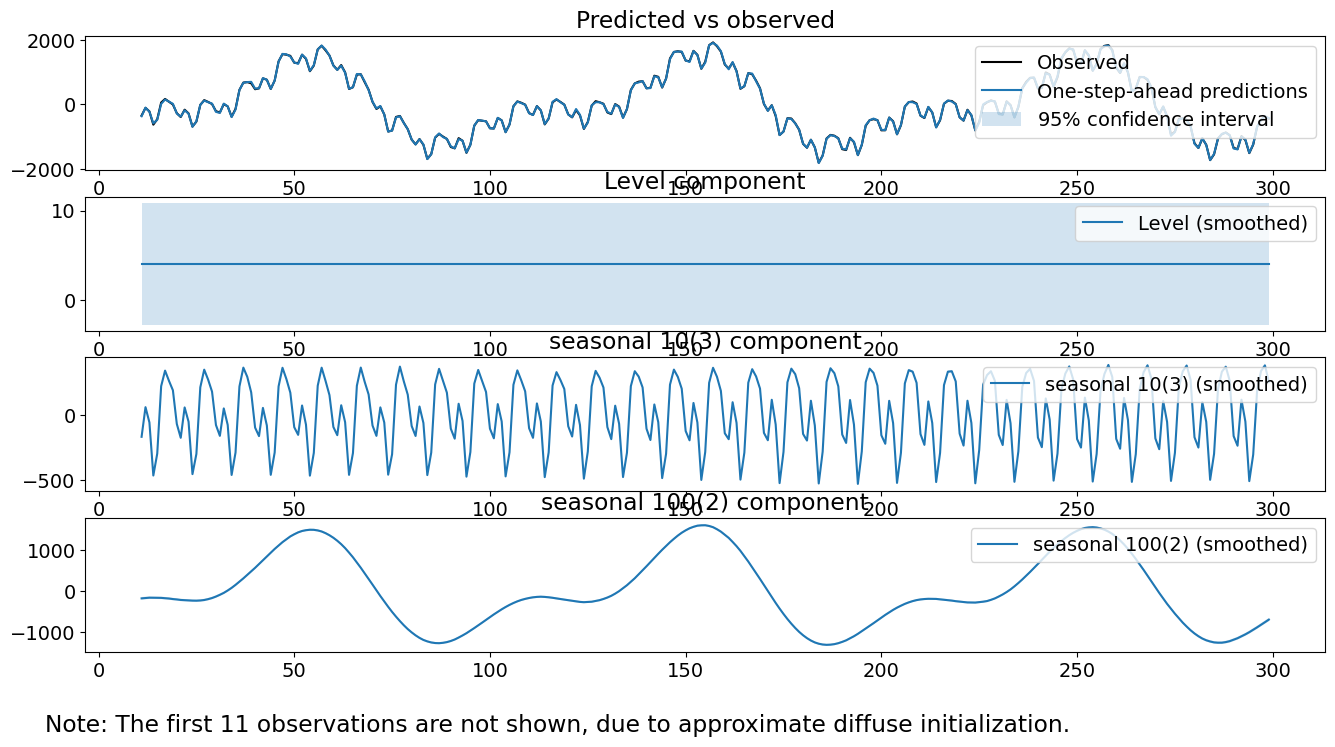

In [5]:
model = sm.tsa.UnobservedComponents(
    series.values,
    level="fixed intercept",
    freq_seasonal=[{"period": 10, "harmonics": 3}, {"period": 100, "harmonics": 2}],
)
res_f = model.fit(disp=False)
print(res_f.summary())
# The first state variable holds our estimate of the intercept
print(
    "fixed intercept estimated as {0:.3f}".format(
        res_f.smoother_results.smoothed_state[0, -1:][0]
    )
)

res_f.plot_components()
plt.show()

In [6]:
model.ssm.transition[:, :, 0]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.80901699,  0.58778525,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.58778525,  0.80901699,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.30901699,  0.95105652,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -0.95105652,  0.30901699,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.30901699,  0.95105652,  0.        ,  0.        ,  0.        ,
         0.   

Observe that the fitted variances are pretty close to the true variances of 4 and 9.  Further, the individual seasonal components look pretty close to the true seasonal components.  The smoothed level term is kind of close to the true level of 10.  Finally, our diagnostics look solid; the test statistics are small enough to fail to reject our three tests.

### Unobserved components (mixed time and frequency domain modeling)

The second method is an unobserved components model, where the trend is modeled as a fixed intercept and the seasonal components are modeled using 10 constants summing to 0 and trigonometric functions with a primary periodicities of 100 with 2 harmonics total.  Note that this is not the generating model, as it presupposes that there are more state errors for the shorter seasonal component than in reality. The process for the time series can be written as:

$$
\begin{align}
y_t & = \mu_t + \gamma^{(1)}_t + \gamma^{(2)}_t + \epsilon_t\\
\mu_{t+1} & = \mu_t \\
\gamma^{(1)}_{t + 1} &= - \sum_{j=1}^9 \gamma^{(1)}_{t + 1 - j} + \omega^{(1)}_t\\
\gamma^{(2)}_{j, t+1} &= \gamma^{(2)}_{j, t}\cos(\lambda_j) + \gamma^{*, (2)}_{j, t}\sin(\lambda_j) + \omega^{(2)}_{j,t}, ~j = 1, 2\\
\gamma^{*, (2)}_{j, t+1} &= -\gamma^{(2)}_{j, t}\sin(\lambda_j) + \gamma^{*, (2)}_{j, t}\cos(\lambda_j) + \omega^{*, (2)}_{j, t}, ~j = 1, 2\\
\end{align}
$$

where $\epsilon_t$ is white noise, $\omega^{(1)}_{t}$ are i.i.d. $N(0, \sigma^2_1)$, and  $\omega^{(2)}_{j,t}$ are i.i.d. $N(0, \sigma^2_2)$.

                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                  300
Model:                                fixed intercept   Log Likelihood               -1238.113
                            + stochastic seasonal(10)   AIC                           2480.226
                   + stochastic freq_seasonal(100(2))   BIC                           2487.538
Date:                                Mon, 12 Jan 2026   HQIC                          2483.157
Time:                                        18:26:20                                         
Sample:                                             0                                         
                                                - 300                                         
Covariance Type:                                  opg                                         
                                  coef    std err 

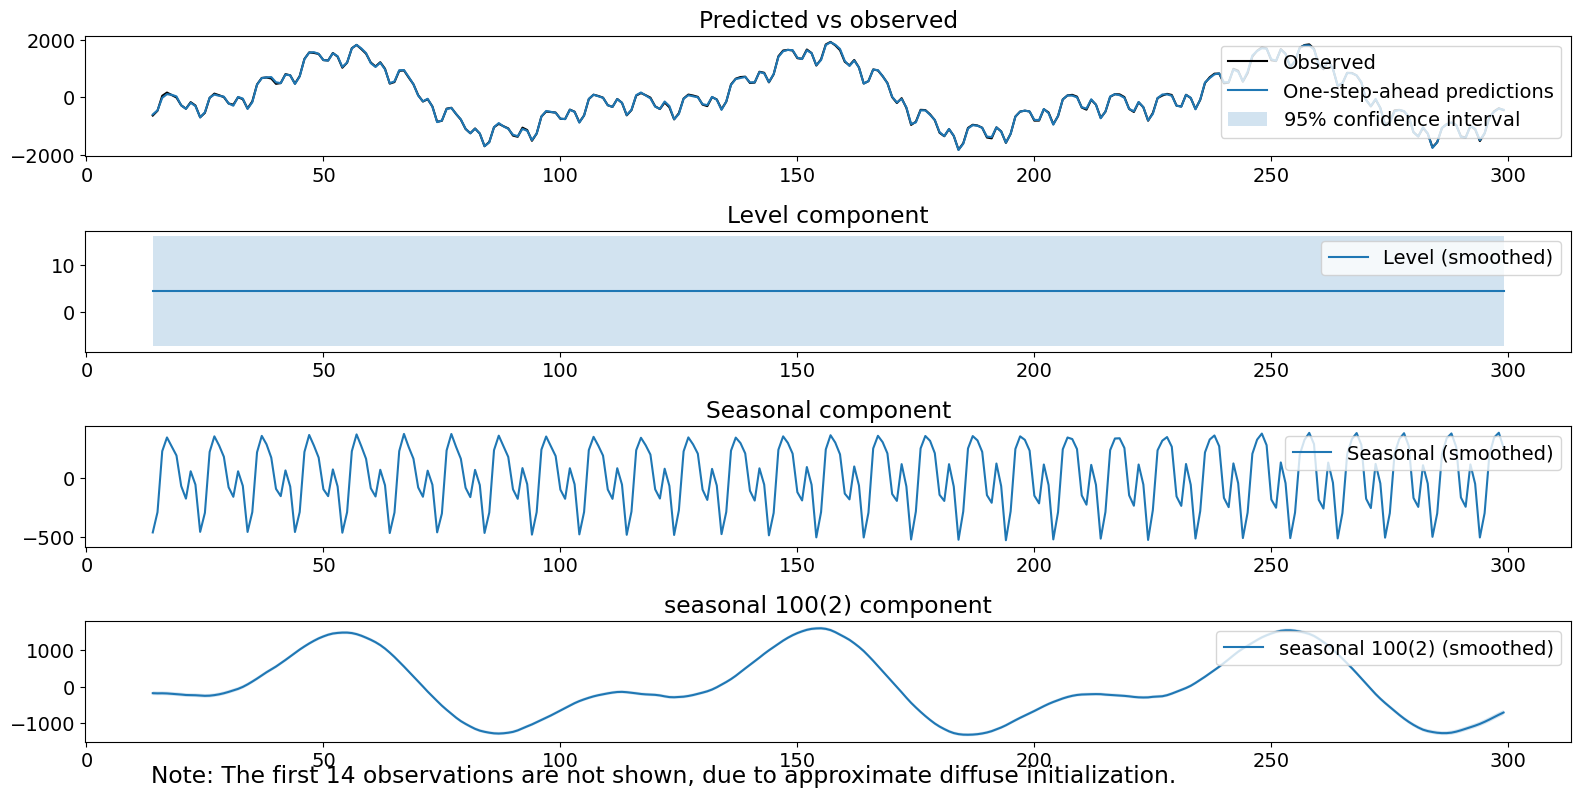

In [7]:
model = sm.tsa.UnobservedComponents(
    series,
    level="fixed intercept",
    seasonal=10,
    freq_seasonal=[{"period": 100, "harmonics": 2}],
)
res_tf = model.fit(disp=False)
print(res_tf.summary())
# The first state variable holds our estimate of the intercept
print(
    "fixed intercept estimated as {0:.3f}".format(
        res_tf.smoother_results.smoothed_state[0, -1:][0]
    )
)

fig = res_tf.plot_components()
fig.tight_layout(pad=1.0)

The plotted components look good.  However, the estimated variance of the second seasonal term is inflated from reality.  Additionally, we reject the Ljung-Box statistic, indicating we may have remaining autocorrelation after accounting for our components.

### Unobserved components (lazy frequency domain modeling)

The third method is an unobserved components model with a fixed intercept and one seasonal component, which is modeled using trigonometric functions with primary periodicity 100 and 50 harmonics. Note that this is not the generating model, as it presupposes that there are more harmonics then in reality.  Because the variances are tied together, we are not able to drive the estimated covariance of the non-existent harmonics to 0.  What is lazy about this model specification is that we have not bothered to specify the two different seasonal components and instead chosen to model them using a single component with enough harmonics to cover both.  We will not be able to capture any differences in variances between the two true components.  The process for the time series can be written as:

$$
\begin{align}
y_t & = \mu_t + \gamma^{(1)}_t + \epsilon_t\\
\mu_{t+1} &= \mu_t\\
\gamma^{(1)}_{t} &= \sum_{j=1}^{50}\gamma^{(1)}_{j, t}\\
\gamma^{(1)}_{j, t+1} &= \gamma^{(1)}_{j, t}\cos(\lambda_j) + \gamma^{*, (1)}_{j, t}\sin(\lambda_j) + \omega^{(1}_{j,t}, ~j = 1, 2, \dots, 50\\
\gamma^{*, (1)}_{j, t+1} &= -\gamma^{(1)}_{j, t}\sin(\lambda_j) + \gamma^{*, (1)}_{j, t}\cos(\lambda_j) + \omega^{*, (1)}_{j, t}, ~j = 1, 2, \dots, 50\\
\end{align}
$$

where $\epsilon_t$ is white noise, $\omega^{(1)}_{t}$ are i.i.d. $N(0, \sigma^2_1)$.

                                 Unobserved Components Results                                 
Dep. Variable:                                       y   No. Observations:                  300
Model:                                 fixed intercept   Log Likelihood               -1101.455
                   + stochastic freq_seasonal(100(50))   AIC                           2204.910
Date:                                 Mon, 12 Jan 2026   BIC                           2208.204
Time:                                         18:32:54   HQIC                          2206.243
Sample:                                              0                                         
                                                 - 300                                         
Covariance Type:                                   opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

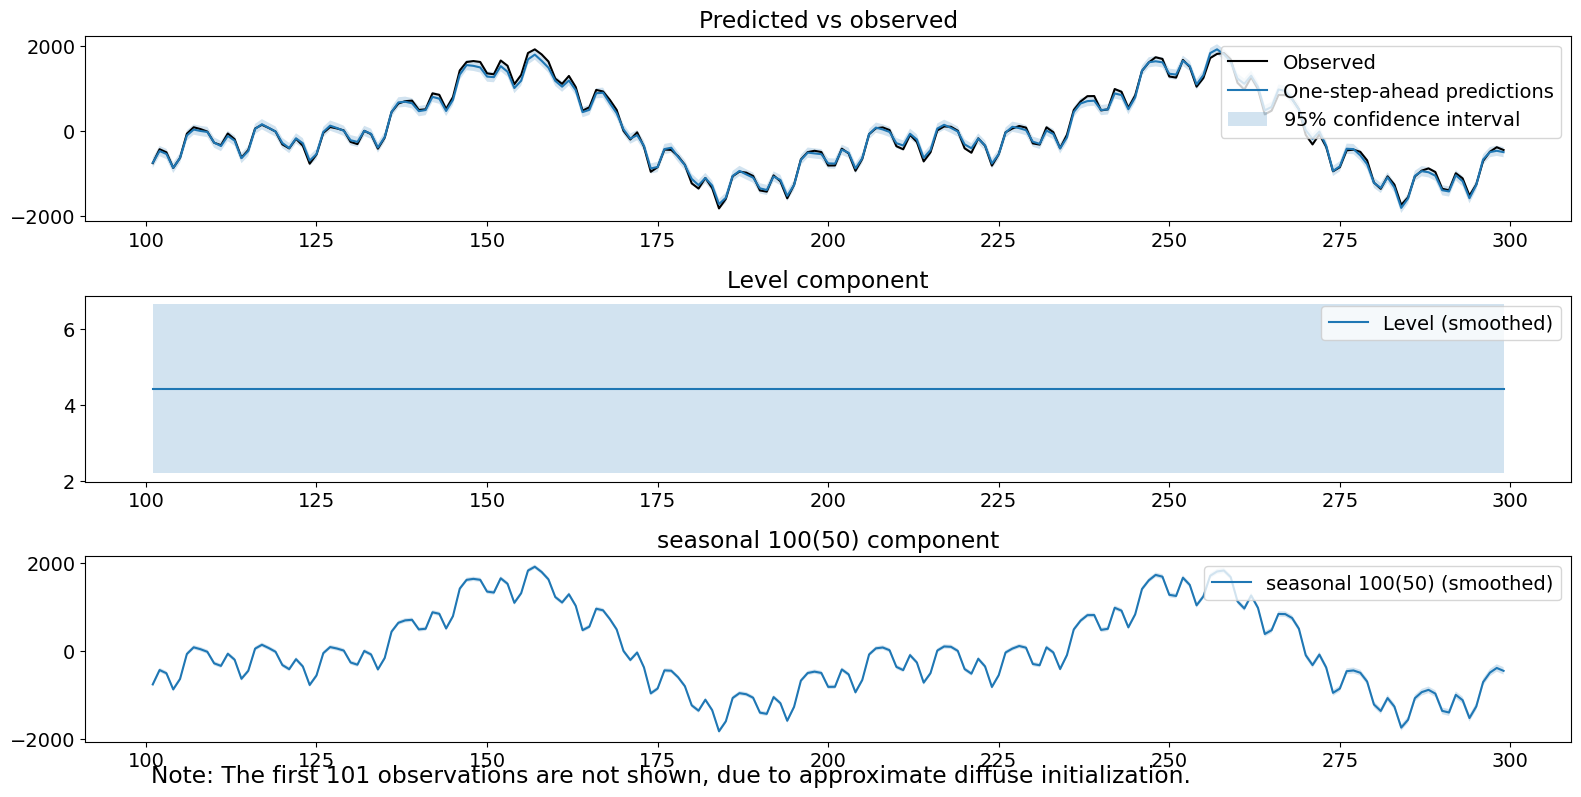

In [8]:
model = sm.tsa.UnobservedComponents(
    series, level="fixed intercept", freq_seasonal=[{"period": 100}]
)
res_lf = model.fit(disp=False)
print(res_lf.summary())
# The first state variable holds our estimate of the intercept
print(
    "fixed intercept estimated as {0:.3f}".format(
        res_lf.smoother_results.smoothed_state[0, -1:][0]
    )
)

fig = res_lf.plot_components()
fig.tight_layout(pad=1.0)

Note that one of our diagnostic tests would be rejected at the .05 level.

### Unobserved components (lazy time domain seasonal modeling)

The fourth method is an unobserved components model with a fixed intercept and a single seasonal component modeled using a time-domain seasonal model of 100 constants. The process for the time series can be written as:

$$
\begin{align}
y_t & =\mu_t + \gamma^{(1)}_t + \epsilon_t\\
\mu_{t+1} &= \mu_{t} \\
\gamma^{(1)}_{t + 1} &= - \sum_{j=1}^{99} \gamma^{(1)}_{t + 1 - j} + \omega^{(1)}_t\\
\end{align}
$$

where $\epsilon_t$ is white noise, $\omega^{(1)}_{t}$ are i.i.d. $N(0, \sigma^2_1)$.

                            Unobserved Components Results                             
Dep. Variable:                              y   No. Observations:                  300
Model:                        fixed intercept   Log Likelihood               -1564.378
                   + stochastic seasonal(100)   AIC                           3130.756
Date:                        Mon, 12 Jan 2026   BIC                           3134.054
Time:                                18:33:14   HQIC                          3132.091
Sample:                                     0                                         
                                        - 300                                         
Covariance Type:                          opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.seasonal  3.558e+05   2.96e+04     12.012 

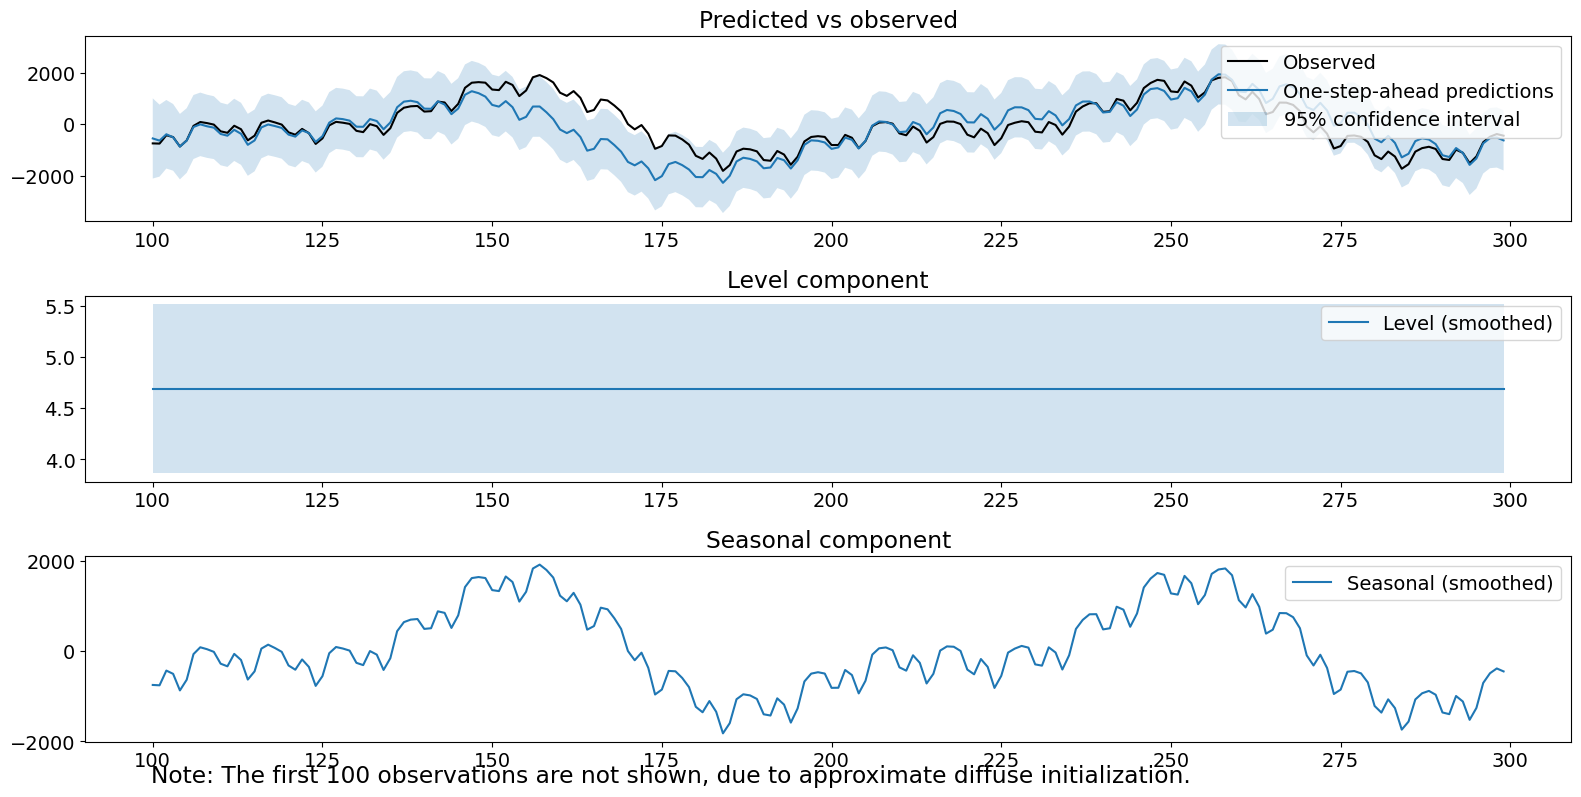

In [9]:
model = sm.tsa.UnobservedComponents(series, level="fixed intercept", seasonal=100)
res_lt = model.fit(disp=False)
print(res_lt.summary())
# The first state variable holds our estimate of the intercept
print(
    "fixed intercept estimated as {0:.3f}".format(
        res_lt.smoother_results.smoothed_state[0, -1:][0]
    )
)

fig = res_lt.plot_components()
fig.tight_layout(pad=1.0)

The seasonal component itself looks good--it is the primary signal.  The estimated variance of the seasonal term is very high ($>10^5$), leading to a lot of uncertainty in our one-step-ahead predictions and slow responsiveness to new data, as evidenced by large errors in one-step ahead predictions and observations. Finally, all three of our diagnostic tests were rejected. 

### Comparison of filtered estimates

The plots below show that explicitly modeling the individual components results in the filtered state being close to the true state within roughly half a period.  The lazy models took longer (almost a full period) to do the same on the combined true state.

In [10]:
# Assign better names for our seasonal terms
true_seasonal_10_3 = terms[0]
true_seasonal_100_2 = terms[1]
true_sum = true_seasonal_10_3 + true_seasonal_100_2

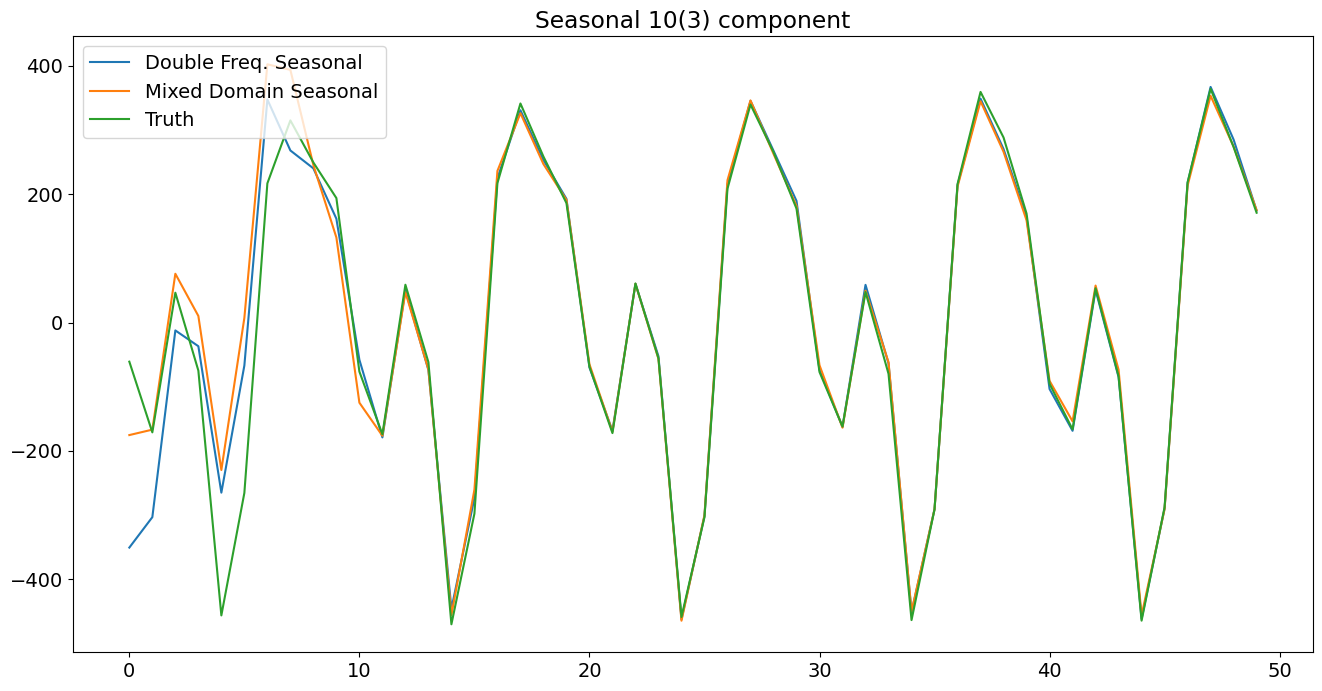

In [11]:
time_s = np.s_[:50]  # After this they basically agree
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
idx = np.asarray(series.index)
(h1,) = ax1.plot(
    idx[time_s], res_f.freq_seasonal[0].filtered[time_s], label="Double Freq. Seas"
)
(h2,) = ax1.plot(
    idx[time_s], res_tf.seasonal.filtered[time_s], label="Mixed Domain Seas"
)
(h3,) = ax1.plot(idx[time_s], true_seasonal_10_3[time_s], label="True Seasonal 10(3)")
plt.legend(
    [h1, h2, h3], ["Double Freq. Seasonal", "Mixed Domain Seasonal", "Truth"], loc=2
)
plt.title("Seasonal 10(3) component")
plt.show()

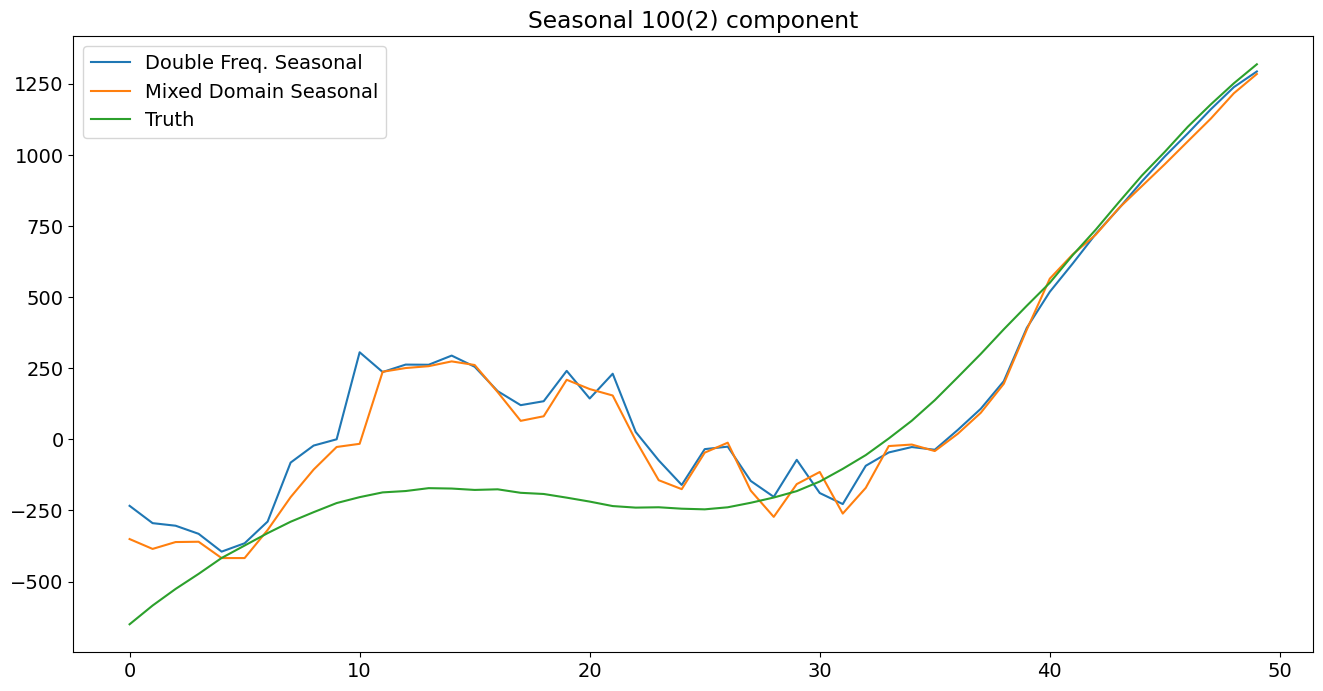

In [12]:
time_s = np.s_[:50]  # After this they basically agree
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
(h21,) = ax2.plot(
    idx[time_s], res_f.freq_seasonal[1].filtered[time_s], label="Double Freq. Seas"
)
(h22,) = ax2.plot(
    idx[time_s], res_tf.freq_seasonal[0].filtered[time_s], label="Mixed Domain Seas"
)
(h23,) = ax2.plot(
    idx[time_s], true_seasonal_100_2[time_s], label="True Seasonal 100(2)"
)
plt.legend(
    [h21, h22, h23], ["Double Freq. Seasonal", "Mixed Domain Seasonal", "Truth"], loc=2
)
plt.title("Seasonal 100(2) component")
plt.show()

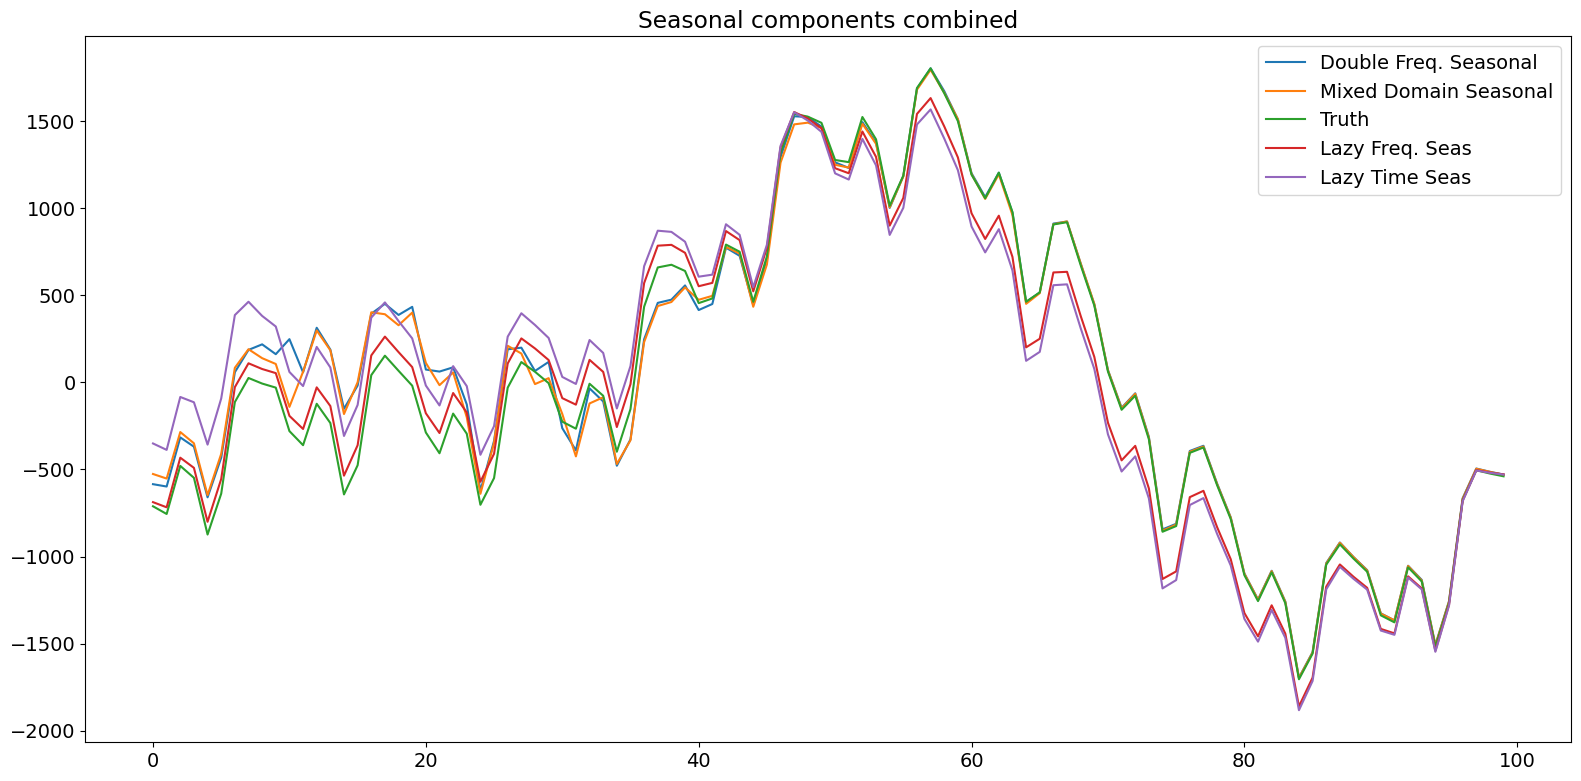

In [13]:
time_s = np.s_[:100]

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
(h31,) = ax3.plot(
    idx[time_s],
    res_f.freq_seasonal[1].filtered[time_s] + res_f.freq_seasonal[0].filtered[time_s],
    label="Double Freq. Seas",
)
(h32,) = ax3.plot(
    idx[time_s],
    res_tf.freq_seasonal[0].filtered[time_s] + res_tf.seasonal.filtered[time_s],
    label="Mixed Domain Seas",
)
(h33,) = ax3.plot(idx[time_s], true_sum[time_s], label="True Seasonal 100(2)")
(h34,) = ax3.plot(
    idx[time_s], res_lf.freq_seasonal[0].filtered[time_s], label="Lazy Freq. Seas"
)
(h35,) = ax3.plot(idx[time_s], res_lt.seasonal.filtered[time_s], label="Lazy Time Seas")

plt.legend(
    [h31, h32, h33, h34, h35],
    [
        "Double Freq. Seasonal",
        "Mixed Domain Seasonal",
        "Truth",
        "Lazy Freq. Seas",
        "Lazy Time Seas",
    ],
    loc=1,
)
plt.title("Seasonal components combined")
plt.tight_layout(pad=1.0)

##### Conclusions

In this notebook, we simulated a time series with two seasonal components of different periods.  We modeled them using structural time series models with (a) two frequency domain components of correct periods and numbers of harmonics, (b) time domain seasonal component for the shorter term and a frequency domain term with correct period and number of harmonics, (c) a single frequency domain term with the longer period and full number of harmonics, and (d) a single time domain term with the longer period.  We saw a variety of diagnostic results, with only the correct generating model, (a), failing to reject any of the tests.  Thus, more flexible seasonal modeling allowing for multiple components with specifiable harmonics can be a useful tool for time series modeling.  Finally, we can represent seasonal components with fewer total states in this way, allowing for the user to attempt to make the bias-variance trade-off themselves instead of being forced to choose "lazy" models, which use a large number of states and incur additional variance as a result.